# Unión de la info de los layouts

### Librerías

In [16]:
import pandas as pd
import os
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import seaborn as sns



In [17]:
df1 = pd.read_csv('layoutsWithTags.csv')
df2 = pd.read_csv('layout_mas.csv', encoding='latin1')

merged_df = pd.merge(df1, df2, on='layout_id')


In [18]:
#merged_df.to_csv('layouts_todo2.csv', index=False)


In [19]:
print(merged_df.head())

   trial_id  layout_id country_x relevant (new) tags  coincidencia  \
0    9446.0      53750    Brazil           2,4,5,6,8          True   
1    9479.0      53772    Brazil          2,4,5,6,11          True   
2    9692.0      53808       USA                 NaN          True   
3    9692.0      53808       USA            1,3,4,10          True   
4    9672.0      53817       USA                 NaN          True   

              field_name              location country_y  latitude  longitude  \
0              LRV_Milho  State of Mato Grosso    Brasil   -12.680    -56.921   
1   Sertanopolis - Milho       State of Paraná    Brasil   -23.058    -51.039   
2                 CF2225                  Iowa       USA    41.878    -93.097   
3                 CF2225                  Iowa       USA    41.878    -93.097   
4  CF2223_B1_10ft_Normal                  Iowa       USA    41.878    -93.097   

       flight_date  
0  2/24/2022 15:32  
1   4/7/2022 16:11  
2  6/28/2022 13:55  
3  6/28/

# Unión info layouts e info foto

In [20]:
layouts_todo = pd.read_csv('layouts_todo2.csv')  
directorio = './images'

filas = []

for index, row in layouts_todo.iterrows():
    layout_id = row['layout_id']
    country = row['country_x']
    relevant = row['relevant (new) tags']
    coincidencia = row['coincidencia']
    imagenes_layout = [filename for filename in os.listdir(directorio) if filename.startswith(str(layout_id) + '_')]
    for filename in imagenes_layout:
        img = Image.open(os.path.join(directorio, filename))
        ancho, alto = img.size
        brillo = img.getextrema()[0][0]
        tonalidad = img.getextrema()[1][0]
        s, _, _ = img.convert('HSV').split()
        estadisticas_saturacion = ImageStat.Stat(s)
        saturacion = estadisticas_saturacion.mean[0]
        layout_info = layouts_todo[layouts_todo['layout_id'] == layout_id].iloc[0]  # Obtener la primera fila coincidente
        field_name = layout_info['field_name']
        location = layout_info['location']
        latitude = layout_info['latitude']
        longitude = layout_info['longitude']
        flight_date = layout_info['flight_date']

        filas.append({
            'trial_id': row['trial_id'],
            'layout_id': layout_id,
            'country': country,
            'relevant (new) tags': relevant,
            'coincidencia': coincidencia,
            'nombre_imagen': filename,
            'ancho': ancho,
            'alto': alto,
            'brillo': brillo,
            'tonalidad': tonalidad,
            'saturacion': saturacion,
            'field_name': field_name,
            'location': location,
            'latitude': latitude,
            'longitude': longitude,
            'flight_date': flight_date
        })
nuevo_df2 = pd.DataFrame(filas)


In [21]:
print(nuevo_df2.head())

   trial_id  layout_id country relevant (new) tags  coincidencia  \
0    9446.0      53750  Brazil           2,4,5,6,8          True   
1    9446.0      53750  Brazil           2,4,5,6,8          True   
2    9446.0      53750  Brazil           2,4,5,6,8          True   
3    9446.0      53750  Brazil           2,4,5,6,8          True   
4    9446.0      53750  Brazil           2,4,5,6,8          True   

        nombre_imagen  ancho  alto  brillo  tonalidad  saturacion field_name  \
0  53750_1-1-10-4.png    927    90       0          0   29.292389  LRV_Milho   
1  53750_1-10-6-6.png    931    90       0          0   49.217222  LRV_Milho   
2  53750_1-10-7-7.png    931    90       0          0   48.946294  LRV_Milho   
3  53750_1-12-1-8.png    933    90       0          0   37.098261  LRV_Milho   
4  53750_1-18-2-7.png    936    90       0          0   30.093863  LRV_Milho   

               location  latitude  longitude      flight_date  
0  State of Mato Grosso    -12.68    -56.921  

In [22]:
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])

nuevo_df2['year'] = nuevo_df2['flight_date'].dt.year

nuevo_df2['month'] = nuevo_df2['flight_date'].dt.month

regiones_unicos = nuevo_df2['location'].unique()

tabla_vuelos = pd.DataFrame()

for region in regiones_unicos:
    df_region = nuevo_df2[nuevo_df2['location'] == region]
    vuelos_por_mes = df_region.groupby(['year', 'month']).size().reset_index(name='count')

    vuelos_por_mes['location'] = region
    tabla_vuelos = pd.concat([tabla_vuelos, vuelos_por_mes])
tabla_vuelos = tabla_vuelos[['location', 'year', 'month', 'count']]

print(tabla_vuelos)


                 location  year  month  count
0    State of Mato Grosso  2022      2     20
0         State of Paraná  2022      4     20
0                    Iowa  2022      6    680
1                    Iowa  2022      7     40
0           Chacabuco, BA  2018     11     20
0               Pergamino  2018     11     20
0           Manuel Ocampo  2018     11     20
0      Carlos Casares, BA  2018     11     40
0        Corral de Bustos  2018     11     20
0            Las Varillas  2019      1     20
0              Rio Cuarto  2019      1     20
0                    ARBA  2021      1    120
1                    ARBA  2021      2    260
0               Las Cejas  2021      1     20
0                 La Cruz  2021      1     20
0                 Mamborê  2021      4     20
0          Wentworth - MO  2021      6     20
0              Galva - IA  2021      5     20
0      Dallas Center - IA  2021      5     60
0         Vermillion - SD  2021      5     20
0            Spencer - SD  2021   

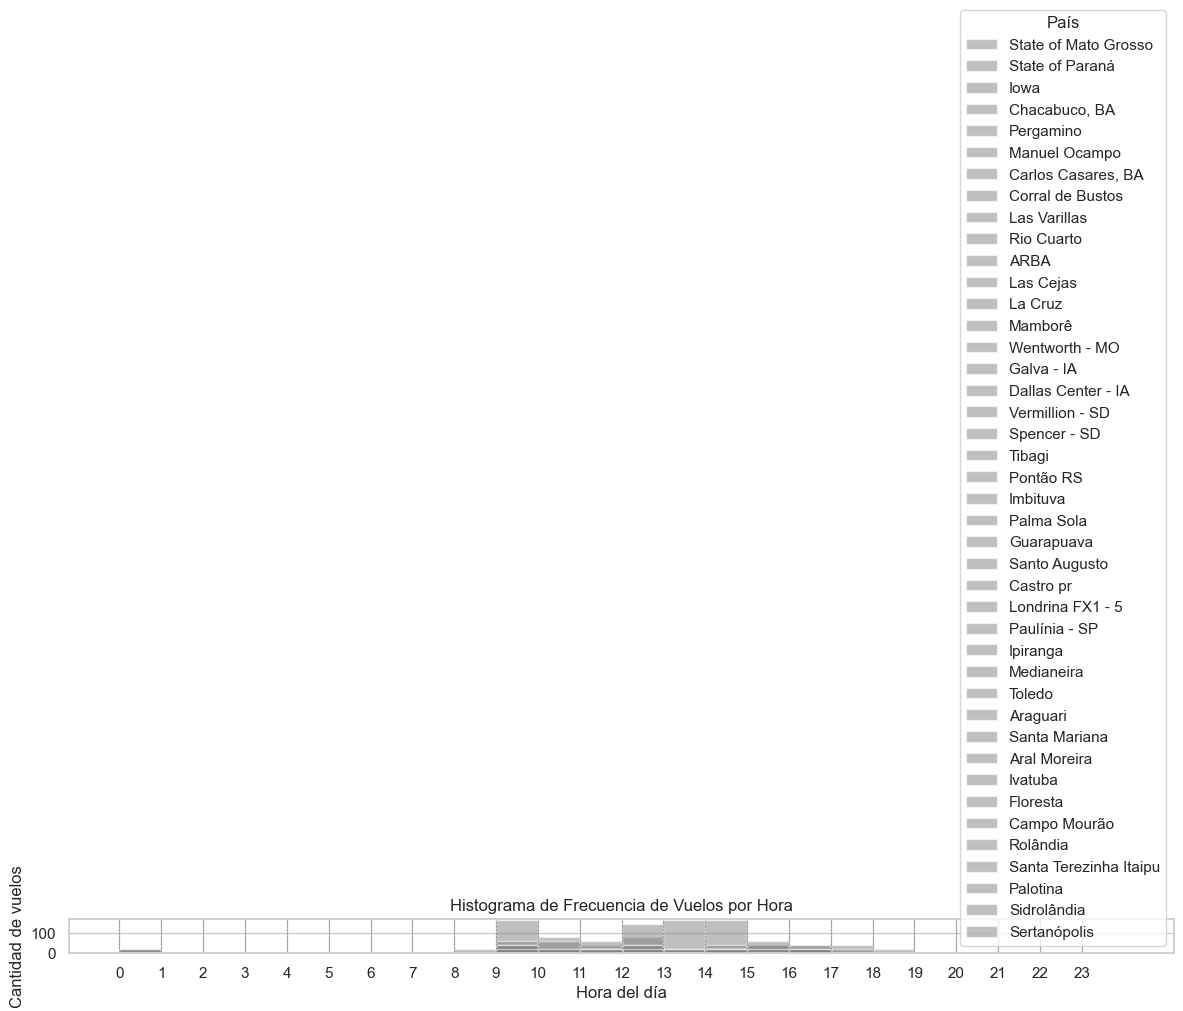

In [23]:
sns.set(style="whitegrid")

regiones = nuevo_df2['location'].unique()



plt.figure(figsize=(12, 6))
for region in regiones:

    data_region = nuevo_df2[nuevo_df2['location'] == region]
    
    frecuencia_horarios = data_region['flight_date'].dt.hour
    
  
    plt.hist(frecuencia_horarios, bins=range(25), alpha=0.5, label=region, color=colores.get(region, 'gray'))


plt.title('Histograma de Frecuencia de Vuelos por Hora')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de vuelos')
plt.xticks(range(24))
plt.legend(title='País')


for hour in range(24):
    plt.axvline(hour, color='gray', linestyle='--', linewidth=0.5)


plt.grid(True)
plt.tight_layout()
plt.show()





## Es bastante similar en todos 
### Rango más común (9;19)

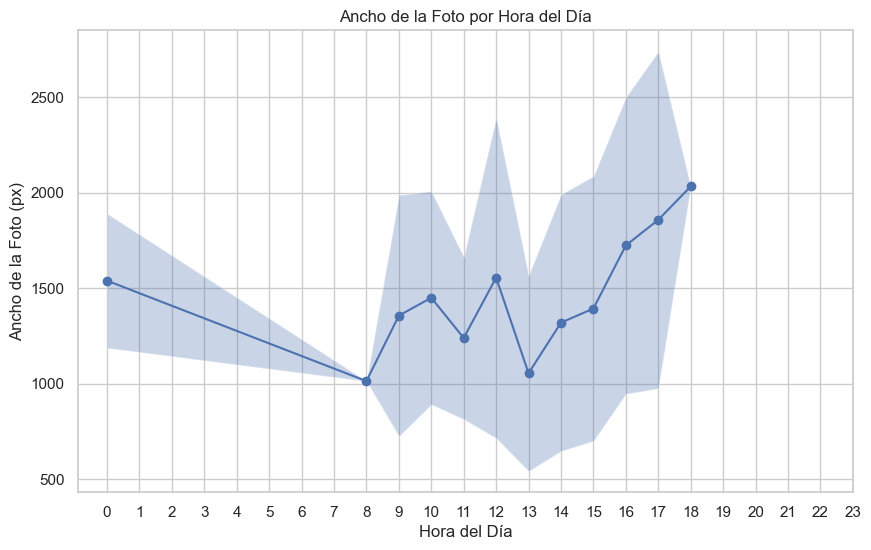

In [24]:

nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])
nuevo_df2['hour_of_day'] = nuevo_df2['flight_date'].dt.hour

grupo_por_hora = nuevo_df2.groupby('hour_of_day')['ancho'].describe()


plt.figure(figsize=(10, 6))
plt.plot(grupo_por_hora.index, grupo_por_hora['mean'], marker='o', linestyle='-')
plt.fill_between(grupo_por_hora.index, grupo_por_hora['mean'] - grupo_por_hora['std'], grupo_por_hora['mean'] + grupo_por_hora['std'], alpha=0.3)
plt.title('Ancho de la Foto por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Ancho de la Foto (px)')
plt.xticks(range(24))
plt.grid(True)
plt.show()


C:\Users\nicky\AppData\Local\Temp\ipykernel_1248\1651243752.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='ancho', data=nuevo_df2, palette='husl')


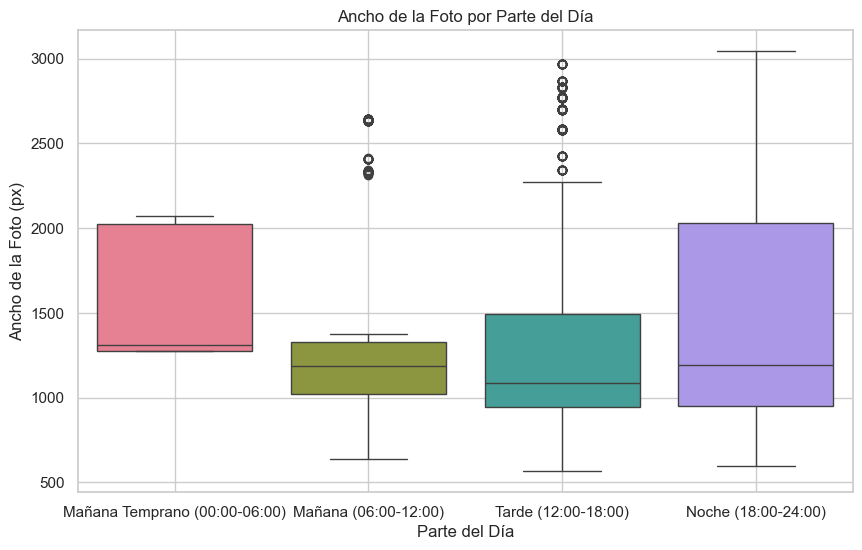

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])
nuevo_df2['hour_of_day'] = nuevo_df2['flight_date'].dt.hour

nuevo_df2['time_of_day'] = pd.cut(nuevo_df2['hour_of_day'], bins=4, labels=['Mañana Temprano (00:00-06:00)', 'Mañana (06:00-12:00)', 'Tarde (12:00-18:00)', 'Noche (18:00-24:00)'])


plt.figure(figsize=(10, 6))
sns.boxplot(x='time_of_day', y='ancho', data=nuevo_df2, palette='husl')
plt.title('Ancho de la Foto por Parte del Día')
plt.xlabel('Parte del Día')
plt.ylabel('Ancho de la Foto (px)')
plt.grid(True)
plt.show()


In [26]:
from scipy.stats import f_oneway

resultados_anova = f_oneway(nuevo_df2[nuevo_df2['time_of_day'] == 'Mañana Temprano (00:00-06:00)']['ancho'],
                            nuevo_df2[nuevo_df2['time_of_day'] == 'Mañana (06:00-12:00)']['ancho'],
                            nuevo_df2[nuevo_df2['time_of_day'] == 'Tarde (12:00-18:00)']['ancho'],
                            nuevo_df2[nuevo_df2['time_of_day'] == 'Noche (18:00-24:00)']['ancho'])


print("Resultados del test ANOVA:")
print("Estadística F:", resultados_anova.statistic)
print("Valor p:", resultados_anova.pvalue)


alpha = 0.05
if resultados_anova.pvalue < alpha:
    print("La media del ancho de la foto depende significativamente del horario del día (rechazamos la hipótesis nula).")
else:
    print("No hay suficiente evidencia para concluir que la media del ancho de la foto depende del horario del día (no rechazamos la hipótesis nula).")


Resultados del test ANOVA:
Estadística F: 7.55334391380607
Valor p: 5.0066500815830916e-05
La media del ancho de la foto depende significativamente del horario del día (rechazamos la hipótesis nula).


## Esta función le está poniendo a todos invierno

In [27]:
import ephem

# Función para calcular la estación del año
def calcular_estacion(fecha, latitud, longitud):
    # Crear un objeto de fecha en la ubicación dada
    observador = ephem.Observer()
    observador.date = fecha

    # Coordenadas para el hemisferio norte (latitud positiva)
    observador.lat = latitud
    observador.long = longitud

    # Calcular el sol
    sol = ephem.Sun()
    sol.compute(observador)

    # Determinar la estación del año
    if sol.alt > 0:
        if 80 <= sol.az <= 100:
            estacion = "Primavera"
        elif 350 <= sol.az <= 10:
            estacion = "Verano"
        elif 260 <= sol.az <= 280:
            estacion = "Otoño"
        else:
            estacion = "Invierno"
    else:
        if 260 <= sol.az <= 280:
            estacion = "Primavera"
        elif 170 <= sol.az <= 190:
            estacion = "Verano"
        elif 80 <= sol.az <= 100:
            estacion = "Otoño"
        else:
            estacion = "Invierno"
    
    return estacion

# Agregar el nuevo campo 'estacion_del_ano' a nuevo_df2
#nuevo_df2['estacion_del_ano'] = nuevo_df2.apply(lambda row: calcular_estacion(row['flight_date'], row['latitude'], row['longitude']), axis=1)


In [28]:

print(nuevo_df2.columns)
print(nuevo_df2['relevant (new) tags'].value_counts)

Index(['trial_id', 'layout_id', 'country', 'relevant (new) tags',
       'coincidencia', 'nombre_imagen', 'ancho', 'alto', 'brillo', 'tonalidad',
       'saturacion', 'field_name', 'location', 'latitude', 'longitude',
       'flight_date', 'year', 'month', 'hour_of_day', 'time_of_day'],
      dtype='object')
<bound method IndexOpsMixin.value_counts of 0          2,4,5,6,8
1          2,4,5,6,8
2          2,4,5,6,8
3          2,4,5,6,8
4          2,4,5,6,8
            ...     
2255    1,3,4,6,7,10
2256    1,3,4,6,7,10
2257    1,3,4,6,7,10
2258    1,3,4,6,7,10
2259    1,3,4,6,7,10
Name: relevant (new) tags, Length: 2260, dtype: object>


In [29]:
# Mapeo de nombres de tags
tag_mapping = {
    '1': 'dark_soil',
    '2': 'red_soil',
    '3': 'high_plant_density',
    '4': 'shadow',
    '5': 'stubble',
    '6': 'weed',
    '7': 'blurry',
    '8': 'dark_image',
    '9': 'bright_image',
    '10': 'grown_plants',
    '11': 'double_plants'
}

# Paso 1: Obtener todos los tags únicos
all_tags = ','.join(nuevo_df2['relevant (new) tags'].fillna('')).split(',')
unique_tags = set(all_tags)

# Paso 2: Eliminar tags no numéricos y convertir a enteros
unique_tags = {int(tag) for tag in unique_tags if tag.isdigit()}

# Paso 3: Crear una nueva columna para cada tag único
for tag in unique_tags:
    # Usar el mapeo de nombres de tags
    column_name = tag_mapping[str(tag)]
    nuevo_df2[column_name] = nuevo_df2['relevant (new) tags'].apply(lambda x: 1 if str(tag) in str(x) else 0)

# Visualizar el DataFrame resultante
print(nuevo_df2.head())

   trial_id  layout_id country relevant (new) tags  coincidencia  \
0    9446.0      53750  Brazil           2,4,5,6,8          True   
1    9446.0      53750  Brazil           2,4,5,6,8          True   
2    9446.0      53750  Brazil           2,4,5,6,8          True   
3    9446.0      53750  Brazil           2,4,5,6,8          True   
4    9446.0      53750  Brazil           2,4,5,6,8          True   

        nombre_imagen  ancho  alto  brillo  tonalidad  ...  red_soil  \
0  53750_1-1-10-4.png    927    90       0          0  ...         1   
1  53750_1-10-6-6.png    931    90       0          0  ...         1   
2  53750_1-10-7-7.png    931    90       0          0  ...         1   
3  53750_1-12-1-8.png    933    90       0          0  ...         1   
4  53750_1-18-2-7.png    936    90       0          0  ...         1   

  high_plant_density shadow  stubble  weed blurry  dark_image  bright_image  \
0                  0      1        1     1      0           1             0   


In [30]:
import pandas as pd

# Calcular el total de registros por país
total_registros_por_region = nuevo_df2.groupby('location').size()

# Crear un DataFrame vacío para almacenar los resultados
proporcion_tags_por_region = pd.DataFrame(columns=['región'])

# Agregar la columna de país
proporcion_tags_por_region['región'] = total_registros_por_region.index

# Calcular la proporción de registros con el tag igual a 1 respecto al total de registros por país para cada tag
for tag in tags_columns:
    # Calcular el total de registros con el tag igual a 1 por país
    total_registros_con_tag_por_region = nuevo_df2.groupby('location')[tag].sum()
    # Calcular la proporción
    proporcion = total_registros_con_tag_por_region / total_registros_por_region
    # Agregar la columna al DataFrame
    proporcion_tags_por_region[tag] = proporcion.values

# Mostrar la tabla
print(proporcion_tags_por_region)




NameError: name 'tags_columns' is not defined

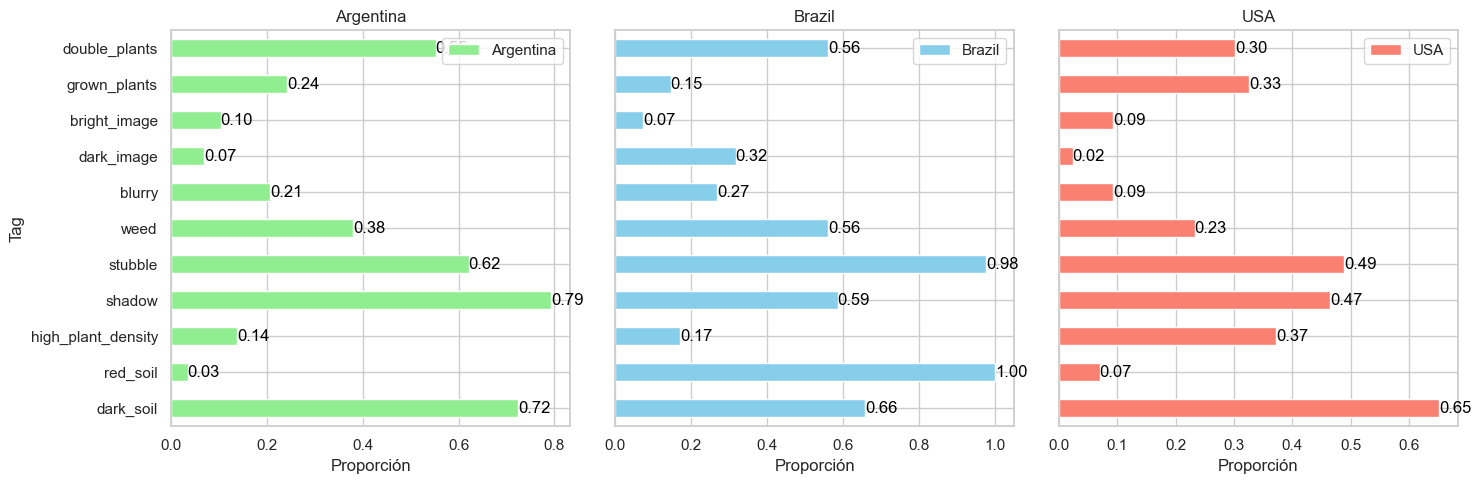

In [ ]:
import matplotlib.pyplot as plt
color_mapping = {'Argentina': 'lightgreen', 'Brazil': 'skyblue', 'USA': 'salmon'}

import matplotlib.pyplot as plt

# Crea una figura con tres subgráficos lado a lado para cada país
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Itera sobre cada país y su proporción de etiquetas
for ax, (_, proporcion) in zip(axes, proporcion_tags_por_region.iterrows()):  
    # Obtiene el color correspondiente al país
    region = proporcion['location']  
    color = color_mapping[region]
    # Crea un gráfico de barras horizontales para cada país con el color correspondiente
    proporcion[1:].plot(kind='barh', ax=ax, color=color)
    ax.set_title(f'{region}')  # Establece el título como el nombre del país
    ax.set_xlabel('Proporción')
    ax.set_ylabel('Tag')
    ax.legend([f'{region}'], loc='upper right')  # Agrega la etiqueta del país en la esquina superior derecha
    
    # Agregar etiquetas de proporción en cada barra
    for i, prop in enumerate(proporcion[1:]):
        ax.text(prop, i, f'{prop:.2f}', ha='left', va='center', color='black')

plt.tight_layout()  # Ajusta el diseño para evitar superposiciones
plt.show()  # Muestra los gráficos





País: Brazil


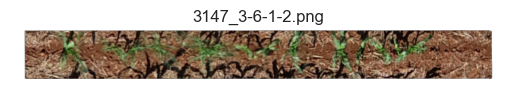

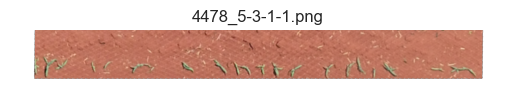

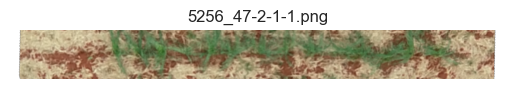

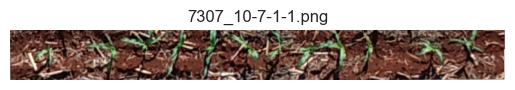

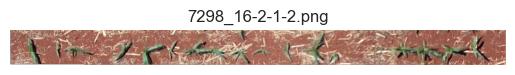

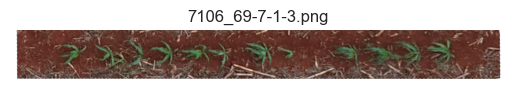

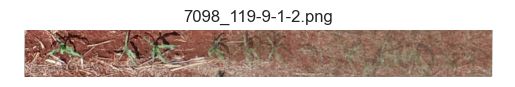

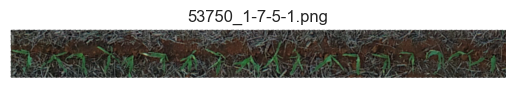

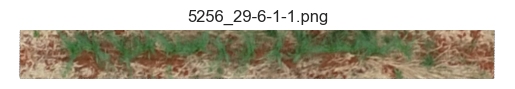

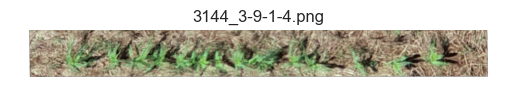

País: USA


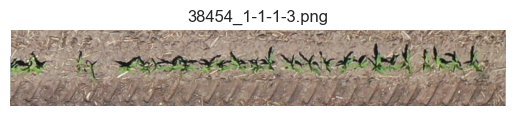

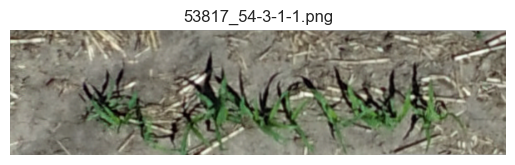

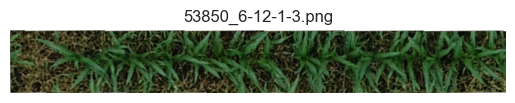

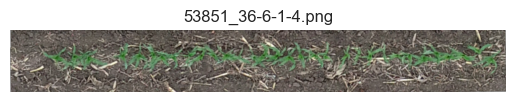

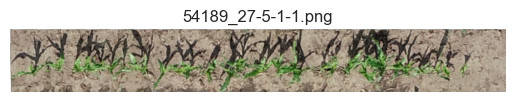

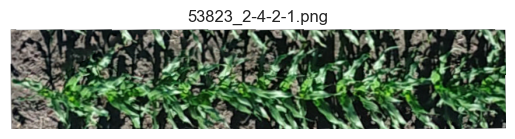

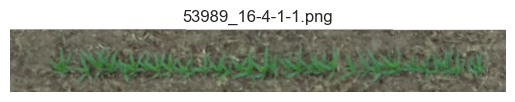

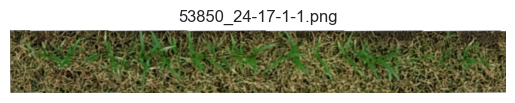

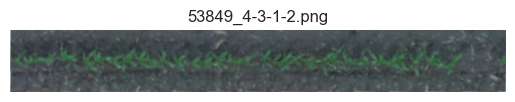

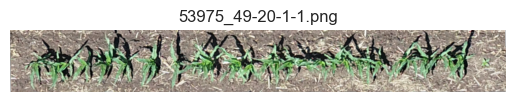

País: Argentina


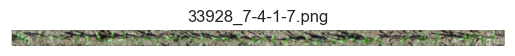

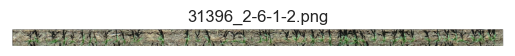

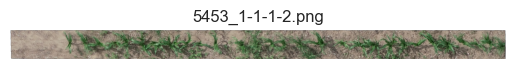

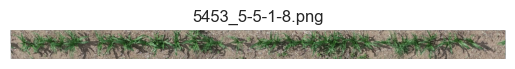

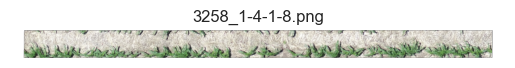

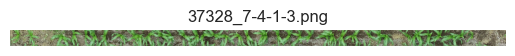

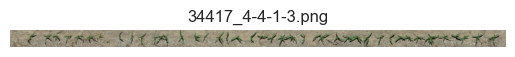

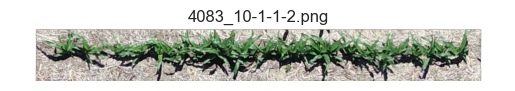

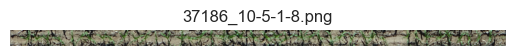

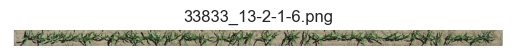

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Función para mostrar una muestra aleatoria de imágenes por país
def mostrar_muestra_aleatoria_por_region(df, directorio, num_muestras=10):
    # Obtener los países únicos
    regiones = df['location'].unique()
    
    # Iterar sobre cada país
    for region in regiones:
        print(f'País: {region}')
        # Filtrar el DataFrame por el país actual
        df_region = df[df['pais'] == region]
        # Obtener una muestra aleatoria de imágenes
        muestra = random.sample(df_region['nombre_imagen'].tolist(), num_muestras)
        
        # Mostrar las imágenes de la muestra
        for imagen_nombre in muestra:
            # Construir la ruta completa de la imagen
            ruta_imagen = os.path.join(directorio, imagen_nombre)
            # Abrir y mostrar la imagen
            imagen = Image.open(ruta_imagen)
            plt.imshow(imagen)
            plt.title(imagen_nombre)
            plt.axis('off')
            plt.show()

# Directorio donde se encuentran las imágenes
directorio_imagenes = './images'

# Llamar a la función para mostrar la muestra aleatoria de imágenes por país
mostrar_muestra_aleatoria_por_region(nuevo_df2, directorio_imagenes)
